# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  |          |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Definindo o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

In [2]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_dataset(classes):
    data = []
    for label, params in classes.items():
        n, columns = params
        
        observations_T = []
        
        for mu, sigma in columns:
            observations_T.append(generate_class(mu, sigma, n))
        
        observations = np.array(observations_T).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1
        
        data.append(np.concatenate([observations, y_true], axis=1))
    
    sorted_data = np.concatenate(data, axis=0)  
    
    return np.random.permutation(sorted_data)

In [3]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1)]),
    3: (1000, [(-5, 1), (-2, 1)]),
}

In [4]:
data = generate_dataset(classes)
print(data[:5])
print(data.shape)

[[-3.63775605 -3.13434996  0.          0.          0.          1.        ]
 [ 6.85601842 -0.9962183   0.          1.          0.          0.        ]
 [-3.27718003 -1.34130546  0.          0.          0.          1.        ]
 [ 9.01641406  1.0643357   1.          0.          0.          0.        ]
 [-0.07202782 -0.25480611  0.          0.          1.          0.        ]]
(4000, 6)


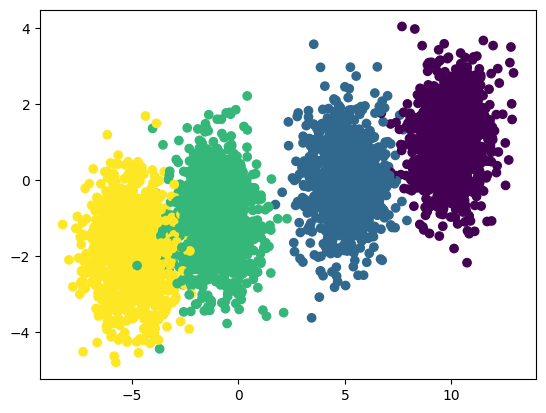

In [5]:
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=labels)

In [6]:
from abc import ABC, abstractmethod


class Error(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass
    
    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass


class MSE(Error):
    def __init__(self):
        pass
    
    def __call__(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def gradient(self, y_true, y_pred):
        return 2 * (y_pred - y_true)


class MLP:
    def __init__(self, layers, error: Error = None):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.activations = []
        self.zs = []
        
        if error is None:
            self.error = MSE()
        else:
            self.error = error
        
        for i in range(1, len(layers)):
            self.weights.append(np.random.randn(layers[i-1], layers[i]))
            self.biases.append(np.random.randn(layers[i]))
            self.activations.append(np.tanh)
            self.zs.append(None)
        self.zs.append(None)
        
    def pred(self, x=None, value=None):
        def _to_class(y):
            return np.argmax(y, axis=1)
        if value is not None:
            return _to_class(value)
        elif x is not None:
            return _to_class(self.forward(x))
        else:
            raise ValueError('x or value must be provided')
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def forward(self, x):
        self.zs[0] = x
        for i in range(len(self.layers) - 1):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            self.zs[i+1] = x
            x = self.activations[i](x)
        return x
    
    def backward(self, x, y):
        y_pred = self.forward(x)
        error = self.error.gradient(y, y_pred)
        for i in range(len(self.layers) - 1, 0, -1):
            error = error * (1 - self.activations[i-1](self.zs[i]) ** 2)
            self.weights[i-1] -= np.dot(self.zs[i-1].T, error)
            self.biases[i-1] -= np.sum(error, axis=0)
            error = np.dot(error, self.weights[i-1].T)
        

In [7]:
# last layer is the output layer so should have same number of neurons as the number of classes
mlp = MLP([2, 3, 4])

y_pred = mlp.forward(data[:, :2])
y_true = data[:, 2:]
pred_labels = mlp.pred(value=y_pred)
labels = np.argmax(y_true, axis=1)

MSE: 0.6818848051886764 Accuracy: 0.174


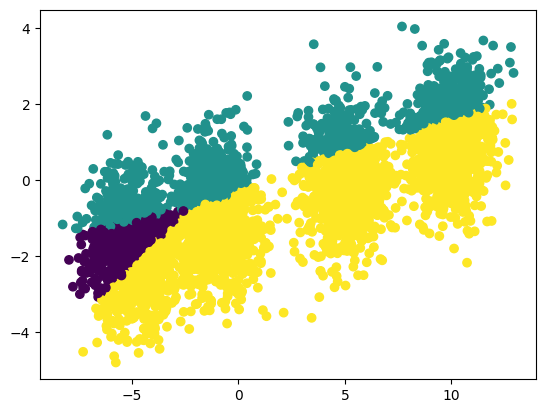

In [8]:
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)
print(
    f'MSE: {mlp.error(y_pred, y_true)}',
    f'Accuracy: {mlp.accuracy(pred_labels, labels)}'
)

In [9]:
gradient = mlp.error.gradient(y_true, y_pred)
print(gradient.shape, y_pred.shape, y_true.shape)
print(gradient)

(4000, 4) (4000, 4) (4000, 4)
[[-9.50197981e-01  5.48872670e-01  4.75130616e-04 -2.02596387e-03]
 [-1.01985647e+00 -1.85235503e+00  1.12993785e+00  1.99945774e+00]
 [-1.73506627e+00  1.82375370e+00 -1.33962109e-01 -1.63133819e-01]
 ...
 [-1.55815225e+00 -1.88951340e+00  1.99697150e+00  1.96334414e+00]
 [ 3.37842108e-01 -3.83627214e+00  1.99480642e+00  1.89740166e+00]
 [ 5.51844586e-01 -3.89873679e+00  1.99705177e+00  1.91000394e+00]]


In [10]:
print(mlp.weights)
update = mlp.backward(data[:, :2], data[:, 2:])
print(mlp.weights)

[array([[-0.35407799, -0.28071887, -0.75241757],
       [ 2.03056822,  0.45854023,  1.4786185 ]]), array([[ 0.48315788, -1.14786265,  1.83990864, -1.29172705],
       [ 0.32916478,  0.16188116, -1.48360595, -1.17769782],
       [-0.67617857,  0.83281631,  0.32656539, -0.70568924]])]
[array([[-39524462.24248686,  -4708995.95610495,  -2109087.4645731 ],
       [ -4166950.23991178,    967249.41028235,   -385372.08855451]]), array([[ -5618.41118441,  -1228.51710804,   -702.91480502,
           164.702395  ],
       [ -6125.14838599,  -3062.32127669,   1689.72453262,
           505.59318833],
       [-12330.51105352,  -6511.24712908,   4274.7488543 ,
          1609.69098371]])]


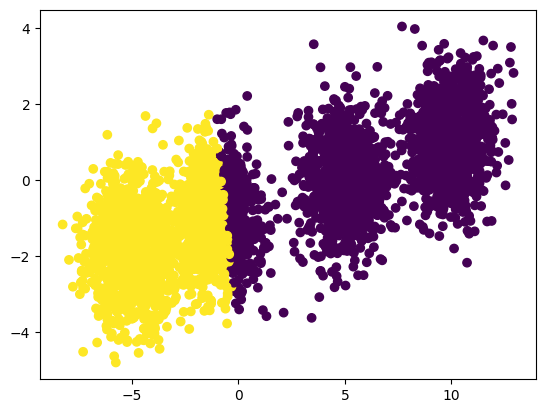

In [11]:
pred_labels = mlp.pred(x=data[:, :2])
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)

In [12]:
class Optimizer(ABC):
    @abstractmethod
    def step(self, mlp: MLP, x, y):
        pass

In [13]:
class SGD(Optimizer):
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def step(self, mlp: MLP, x, y):
        y_pred = mlp.forward(x)
        mlp.backward(x, y)

In [14]:
mlp = MLP([2, 3, 4])
sgd = SGD()

acc = -np.inf

for i in range(1000):
    sgd.step(mlp, data[:, :2], data[:, 2:])
    if i % 100 == 0:
        y_pred = mlp.forward(data[:, :2])
        pred_labels = mlp.pred(value=y_pred)
        labels = np.argmax(data[:, 2:], axis=1)
        err = mlp.error(y_pred, data[:, 2:])
        print(
            f'MSE: {mlp.error(y_pred, data[:, 2:])}',
            f'Accuracy: {mlp.accuracy(pred_labels, labels)}'
        )
        
        if acc == 1 or np.isclose(acc, mlp.accuracy(pred_labels, labels)):
            print('Converged')
            break
        acc = mlp.accuracy(pred_labels, labels)


MSE: 1.003 Accuracy: 0.27625
MSE: 1.003 Accuracy: 0.27625
Converged


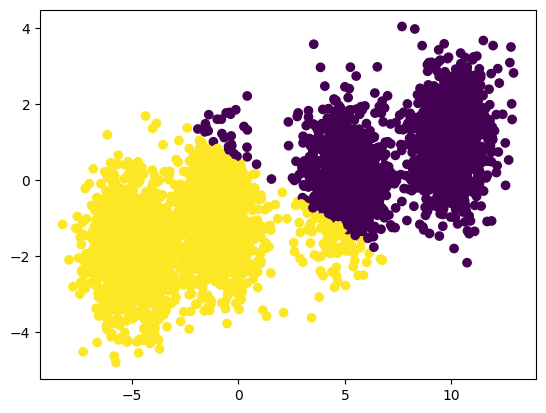

In [15]:
pred_labels = mlp.pred(x=data[:, :2])
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=pred_labels)